In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()

# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS
from src.jpg_quality_pil_magick import get_jpg_quality


In [3]:
mbtnames_fr = {
    1: 'IGNt1-Mercantour-Ubaye-Antibes-Embrun.mbtiles',  # 1.3GB
    # Préalpes, Trois-Evéchés, Pelat, Mercantour-Argentera, Parpaillon, Chambeyron
    2: 'IGNt2-Digne-Aups-Eguilles-Gap.mbtiles',  # 1.3 GB
    # Préalpes de Digne, Lubéron, Vaucluse, Baronnies, Bochaine, Diois-S
    3: 'IGNt3-Vercors-Ecrins-Cerces.mbtiles',  # 1.2
    # Vercors, Taillefer, Dévoluy, Ecrins, Cerces, Queyras, Escreins
    # coupé en 2 t3/t4: Grandes Rousses, Arves, Cerces
    4: 'IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles',  # 1 GB
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    5: 'IGNt5-MontBlanc-Chambery-Evian.mbtiles'  # 1.1 GB
    # Bauges, Beaufortain, Bornes, Aravis, Mont-Blanc, Aiguilles Rouges, Giffre, Chablais
}
mbtnames_merged = {
    1: 'alps1-Mercantour-Ubaye-Cuneese',
    2: '',  # IGNt2 - no change
    3: 'alps3-Vercors-Ecrins-Queyras-Cozie',
    # it3: Alpes Cozie (Cotiennes) ; Monviso
    4: 'alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso',
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    # it: Alpes Grées/Alpi Graie: Lanzo, Susa
    5: 'alps5-Mont-Blanc-Leman-Cervino-Cogne'
    # it: Gran Paradiso N, Cervino
}

In [4]:
# This could be useful to restrict the area to merge to speed it up
border_zones = {
    4: dict(west=6.62, east=7.19),
    3: dict(west= 6.64, east=7.08),
    1: dict(west=6.85, east=7.72)  # instead of 8.174 for bug
}

In [5]:
fritN = 4
workdir = f'frit{fritN}/'
os.makedirs(workdir, exist_ok=True)

orig = pjoin(realpath('../../mapdata/mobac_atlases'), mbtnames_fr[fritN])
mbtfr = pjoin(workdir, f'fr{fritN}.mbtiles')
!ln -sf "$orig" "$mbtfr"
M.mbt_info(mbtfr)

'zoom = 9 16 ; n = 49153 * 20 kb/tile q = 75 ; bounds = 5.625,45.089,7.732,45.583 ; format = jpg ; name = IGNt4-Chartreuse-Vanoise Chambery-Bardon'

In [6]:
finalname = mbtnames_merged[fritN]
finalpath = pjoin(workdir, finalname + '.mbtiles')

In [38]:
mbtitall = '../../mapdata/mbtiles/Bugianen.mbtiles'
M.mbt_info(mbtitall)

'zoom = 12 16 ; n = 152742 * 23 kb/tile q = 80 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen'

In [7]:
M.mbt_info(finalpath)

'zoom = 9 16 ; n = 64814 * 45 kb/tile q = 99 ; bounds = 5.625,45.08904,8.4375,45.58329 ; center = 7.03125,45.33616,9 ; format = jpg ; name = alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso'

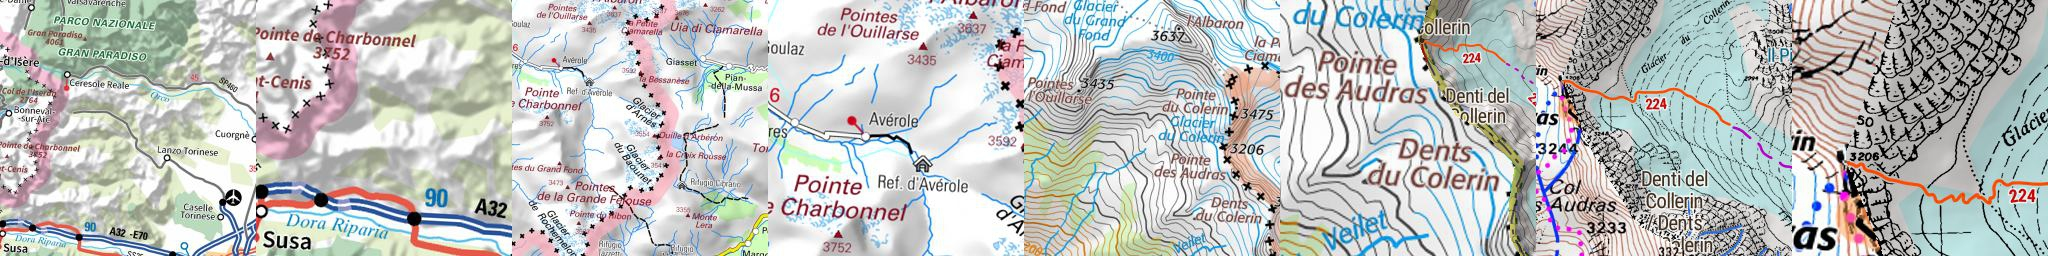

In [13]:
MY.tile_pyramid('/tmp/a.jpg', ll=T.LngLat(7.11, 45.32), mbt=finalpath)
display(Image('/tmp/a.jpg'))

# Annex - inspection

b'\xff\xd8\xff\xe0\x00\x10JFIF'


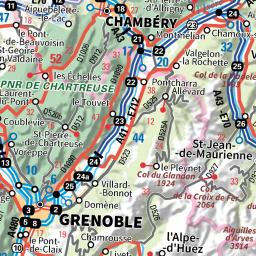

In [14]:
z, x, y, img = next(M.get_all_tiles(finalpath))
print(img[:10])
display(Image(img))

In [15]:
z, x, y, img = next(M.get_all_tiles(finalpath))


In [16]:
import io
pim = Img.open(io.BytesIO(img))

In [17]:
bb = M.get_bounds(finalpath)
bb

LngLatBbox(west=5.625, south=45.08904, east=8.4375, north=45.58329)

In [18]:
from src.jpg_quality_pil_magick import get_jpg_quality

In [19]:
# whi 45 kb/tile?
eps = 0.001
for lng, lat in ((bb.west+eps, bb.south+eps),(bb.west+eps, bb.north-eps),
                 (bb.east-1, bb.north-eps), (bb.east-1, bb.south+eps)):
    row = M.lnglat2tile(finalpath, z=16, lng=lng, lat=lat, what='*')
    if row:
        pim = Img.open(io.BytesIO(row[-1]))
        print(row[:-1], get_jpg_quality(pim))
    else:
        print('?')


(16, 33792, 41984) 99
(16, 33792, 42111) 99
(16, 34121, 42111) 99
(16, 34121, 41984) 99


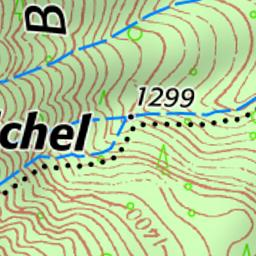

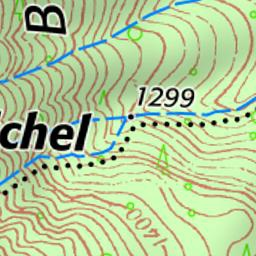

In [20]:
lng, lat = (bb.west+eps, bb.south+eps)
to = M.lnglat2tile(mbtfr, z=16, lng=lng, lat=lat)
tn = M.lnglat2tile(finalpath, z=16, lng=lng, lat=lat)
display(Image(to))
display(Image(tn))

In [21]:
pto = Img.open(io.BytesIO(to))
ptn = Img.open(io.BytesIO(tn))
print(len(to)//1024, len(tn) // 1024, '\n',
      get_jpg_quality(pto), get_jpg_quality(ptn) )

18 37 
 75 99


In [22]:
ato, atn = np.array(pto), np.array(ptn)

0.005482912063598633
0.9997361885691018


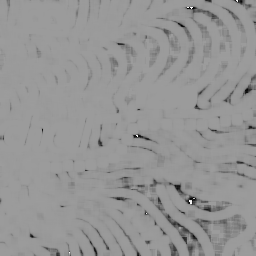

In [24]:
import skimage
from skimage.metrics import structural_similarity
s = time()
scoreg , diffg = structural_similarity(np.array(pto.convert('L')),
                      np.array(ptn.convert('L')), full=True)
print(time() - s)
print(scoreg)
Img.fromarray((diffg * 255 * 100).astype(np.uint8))

In [27]:
# operating in RGB space is 3x slower than greyscale
s = time()
(score, diff) = structural_similarity(np.array(pto),
                      np.array(ptn), channel_axis=2, full=True)
time() - s


0.012634038925170898

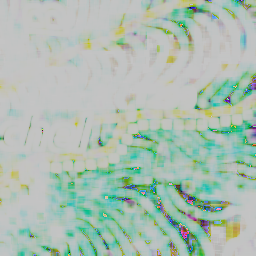

In [28]:
# x60: arbitrary mangification factor
Img.fromarray((diff * 255 * 60).astype(np.uint8))

In [ ]:
with M.cursor(finalpath) as dbc:
    dbc.execute('ATTACH ? AS help', (mbtfr,))
    dbc.execute('ATTACH ? AS help2', (mbtitall,))
    q = """SELECT t0.zoom_level, t0.tile_column, t0.tile_row, t0.tile_data
            FROM main.tiles t0
            LEFT  JOIN help.tiles t1
                ON t0.zoom_level = t1.zoom_level
                AND t0.tile_column = t1.tile_column
                AND t0.tile_row = t1.tile_row
            LEFT  JOIN help2.tiles t2
                ON t0.zoom_level = t1.zoom_level
                AND t0.tile_column = t1.tile_column
                AND t0.tile_row = t1.tile_row
            LIMIT 1
            """
    print(dbc.execute(q).fetchall())

In [ ]:
dbc.__enter__()

In [47]:
from collections import defaultdict
import sqlite3

from src.mbt_download import catchtime

def choose_similar(z, x, y, tile_toedit, tile_help, tile_help2):
    ptn = Img.open(io.BytesIO(tile_toedit))
    pto = Img.open(io.BytesIO(tile_help))
    scoreg , diffg = structural_similarity(
                        np.array(pto.convert('L')),
                        np.array(ptn.convert('L')), full=True)
    if score > 0.99:
        return '1', tile_help
    else:
        pto = Img.open(io.BytesIO(tile_help2))
        scoreg , diffg = structural_similarity(
                        np.array(pto.convert('L')),
                        np.array(ptn.convert('L')), full=True)
        if score > 0.99:
            return '2', tile_help2
        return '', None

def compactdict(d:dict):
    smartstr = lambda e: str(round(e, 2)) if isinstance(e, float) else str(e)
    return ', '.join(':'.join(map(smartstr, kv)) for kv in d.items())

# replace_if_similar

def get_joined_tiles_3(dbc, q='', arraysize=1000): # <- ~30MB RAM
        """
        sqlite3 alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso.mbtiles
        ATTACH "../mobac_atlases/IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles" AS help;

        """
        dbc.execute(
            """SELECT t0.zoom_level, t0.tile_column, t0.tile_row, t0.tile_data, t1.tile_data, t2.tile_data
            FROM main.tiles t0
            LEFT JOIN help.tiles t1
                ON t0.zoom_level = t1.zoom_level
                AND t0.tile_column = t1.tile_column
                AND t0.tile_row = t1.tile_row
            LEFT JOIN help2.tiles t2
                ON t0.zoom_level = t1.zoom_level
                AND t0.tile_column = t1.tile_column
                AND t0.tile_row = t1.tile_row
            """ + q)
        while rows:= dbc.fetchmany(arraysize):
            for row in rows:
                yield row

def process_tiles(mbt_toedit, mbt_help, mbt_help2, q, get_tiles_cbk, merge_cbk, debugmode=False):
    """
    Generic merge function
    * for now used to retrieve original version of recompressed jg tile
    * could be adapted for the swisstopo retina merge
    """
    stmt_copy_rows = f'''
        UPDATE main.tiles AS mt SET tile_data = (
            SELECT ht.tile_data FROM help.tiles ht
            WHERE ht.zoom_level = mt.zoom_level AND ht.tile_column=mt.tile_column AND ht.tile_row = mt.tile_row
        ) WHERE zoom_level=? AND tile_column=? AND tile_row=?
    '''

    assert os.path.exists(mbt_toedit)
    assert os.path.exists(mbt_help)
    db  = sqlite3.connect(mbt_toedit, isolation_level="DEFERRED")
    dbc = db.cursor()
    ntiles = M.tile_count(dbc)
    dbc.execute(f'ATTACH ? AS help', (mbt_help,))
    if mbt_help2:
        assert os.path.exists(mbt_help2)
        dbc.execute(f'ATTACH ? AS help2', (mbt_help2,))

    reasons = defaultdict(int)
    elpsd = defaultdict(float)
    copyrows = []
    insrows = []
    rmrows = []
    tilelogname = f'log_{os.path.basename(mbt_toedit)}_{time()}.log'
    f = open(tilelogname, 'w')

    def dbsync():
        nonlocal copyrows, insrows, rmrows, elpsd
        if copyrows or rmrows or insrows:
            with catchtime() as tic:
                dbc.executemany(stmt_copy_rows, copyrows)
                M.remove_tiles(dbc, zxys=rmrows)
            elpsd['db_copyrm'] += tic.time
            with catchtime() as tii:
                M.insert_tiles(dbc, insrows)
            elpsd['db_insert'] += tii.time
            print(f'#{i}/{ntiles}, z{z}: Inserted {len(copyrows)} in {tii.time:.1f}s and copied {len(copyrows)} '
                  f'and removed {len(rmrows)} in {tic.time:.1f}s')
            copyrows = []
            rmrows = []
            insrows = []
            f.flush()

    try:
        for i, (z, x, y, imd1, imd2, imd3) in enumerate(get_tiles_cbk(dbc, q=q), start=1):
            # has_help = lambda: M.num2tile(dbc, z, x, y, flip_y=False, what='1', dbname='help')
            if i % 1000 == 1:
                print(f'#{i}/{ntiles}, z{z}:', compactdict(reasons))
                print(f'#{i}/{ntiles}, z{z}:', compactdict(elpsd))
                db.commit()
            if i % 200 == 1 and copyrows:
                dbsync()
            reason, imd = merge_cbk(z, x, y, imd1, imd2, imd3)
            reasons[reason] += 1
            if reason:
                insrows.append((z, x, y, imd))

        return tilelogname
    finally:
        try:
            dbsync()
            print(compactdict(elpsd))
            print(compactdict(reasons))
        finally:
            try:
                db.commit()
                dbc.close()
                db.close()
            finally:
                f.close()



In [49]:

process_tiles(finalpath, mbtfr, mbtitall,
              q='WHERE t0.zoom_level IN (15, 16)',
              get_tiles_cbk=get_joined_tiles_3, merge_cbk=choose_similar)

#1/64814, z15: 
#1/64814, z15: 
#1001/64814, z15: 1:1000
#1001/64814, z15: 
#2001/64814, z15: 1:2000
#2001/64814, z15: 
#3001/64814, z15: 1:3000
#3001/64814, z15: 
#4001/64814, z15: 1:4000
#4001/64814, z15: 
#5001/64814, z15: 1:5000
#5001/64814, z15: 
#6001/64814, z15: 1:6000
#6001/64814, z15: 
#7001/64814, z15: 1:7000
#7001/64814, z15: 
#8001/64814, z15: 1:8000
#8001/64814, z15: 
#9001/64814, z15: 1:9000
#9001/64814, z15: 
#10001/64814, z15: 1:10000
#10001/64814, z15: 
#11001/64814, z15: 1:11000
#11001/64814, z15: 
#12001/64814, z15: 1:12000
#12001/64814, z15: 
#13001/64814, z15: 1:13000
#13001/64814, z15: 
#14001/64814, z15: 1:14000
#14001/64814, z15: 
#15001/64814, z15: 1:15000
#15001/64814, z15: 
#16001/64814, z15: 1:16000
#16001/64814, z15: 
#17001/64814, z15: 1:17000
#17001/64814, z15: 
#18001/64814, z15: 1:18000
#18001/64814, z15: 
#19001/64814, z15: 1:19000
#19001/64814, z15: 
#20001/64814, z15: 1:20000
#20001/64814, z15: 
#21001/64814, z15: 1:21000
#21001/64814, z15: 
#22001/6

In [ ]:
fritN = 3
process_tiles(mbtnames_merged[fritN], pjoin(workdir, f'fr{fritN}.mbtiles'), mbtitall,
              q='WHERE t0.zoom_level IN (15, 16)',
              get_tiles_cbk=get_joined_tiles_3, merge_cbk=choose_similar)
fritN = 4

: 

: 